# <img style="float: left; padding-right: 10px; width: 200px" src="https://raw.githubusercontent.com/trivikverma/researchgroup/master/assets/media/logo.png"> EPA-1316A Introduction to *Urban* Data Science 


## Lab 4 - Part 1: Networks and Spatial Weights

**TU Delft**<br>
**Q1 2022**<br>
**Instructor:** Trivik Verma <br>
**TAs:** Auriane Técourt, Dorukhan Yeşilli, Ludovica Bindi, Nicolò Canal, Ruth Nelson, Vaibhavi Srivastava <br>
**[Centre for Urban Science & Policy]( https://cusp.tbm.tudelft.nl/)** <br>

---


## Table of Contents

* [Learning Goals](#chapter0)
* [Street Networks](#chapter1)
    * [Overview demonstration of OSMnx](#section1_1)
    * [Get shapefiles from OpenStreetMap](#section1_2)
    * [Download and construct street networks](#section1_3)
        * [Method 1: Pass a bounding box](#section1_3_1)
        * [Method 2: Pass a lat-long point and bounding box distance in meters](#section1_3_2)
        * [Method 3: Pass a (lat,lon) point and network distance in meters ](#section1_3_3)
        * [Method 4: Pass an address and distance (bounding box or network) in meters](#section1_3_4)
        * [Method 5: Pass a place name](#section1_3_5)
    * [Simlifying street network topography](#section1_4)
    * [Saving networks to disk](#section1_5)
    * [Calculate basic network metrics](#section1_6)
* [Use OSMnx to create and analyze a NetworkX street network](#chapter2)
    * [Calculate basic (and more advanced) street network metrics](#section2_1)
    * [Inside a Networkx graph](#section2_2)
* [Spatial Weights](#chapter3)
    * [Data](#section3_1)
    * [Building spatial weights in PySAL](#section3_2)
        * [Contiguity](#section3_2_1)
        * [Distance](#section3_2_2)
        * [Block weights](#section3_2_2)
    * [Standardizing `W` matrices](#section3_3)
    * [Reading and Writing spatial weights in `PySAL`](#section3_4)
    * [Spatial Lag](#section3_5)
    * [Moran Plot](#section3_6)
    

## Learning Goals <a class="anchor" id="chapter0"></a>

1. Understand how to use OSMnx and create visualisations of street networks using it. 
1. Develop an understanding of the different methods that can be used to construct networks.
1. Understand the concept of spatial weights & spatial lag and use the same to create a Moran plot.


## Street Networks <a class="anchor" id="chapter1"></a>

### Overview demonstration of OSMnx <a class="anchor" id="section1_1"></a>

OSMnx is a Python library that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API. More about OSMnx from the creator Geoff Boeing directly: https://github.com/gboeing/osmnx

It is already within the installation file or the docker image that you used at the beginning of the course. If you are following a third way, you can install it as follows.

Install OSMnx: `conda install -c conda-forge osmnx`

Note: If you wish to revisit the section on APIs, you can find it in Lab 1.

In [1]:
import osmnx as ox, geopandas as gpd
import pandas as pd
%matplotlib inline
ox.settings.log_console=True
ox.settings.use_cache=True

### Get shapefiles from OpenStreetMap <a class="anchor" id="section1_2"></a>

OSMnx lets you download spatial "place boundary" geometries from OpenStreetMap, save them to shapefiles, project them, and plot them. For a more in-depth demonstration of creating these shapefiles, see [OSMnx examples](https://github.com/gboeing/osmnx).

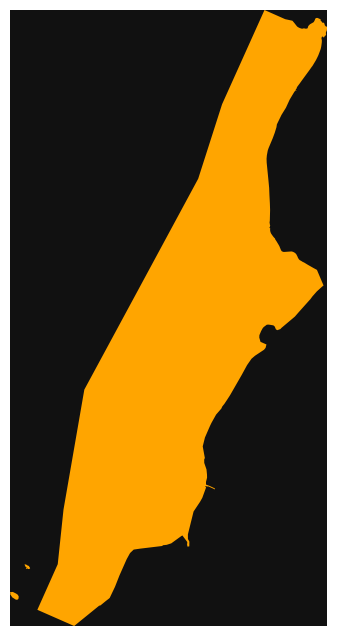

In [2]:
gdf = ox.geocode_to_gdf('Manhattan, New York, NY, USA')
#gdf = gdf.append(_geocode_query_to_gdf('Manhattan, New York, NY, USA'))
area = ox.project_gdf(gdf)
fig, ax = ox.plot_footprints(area)

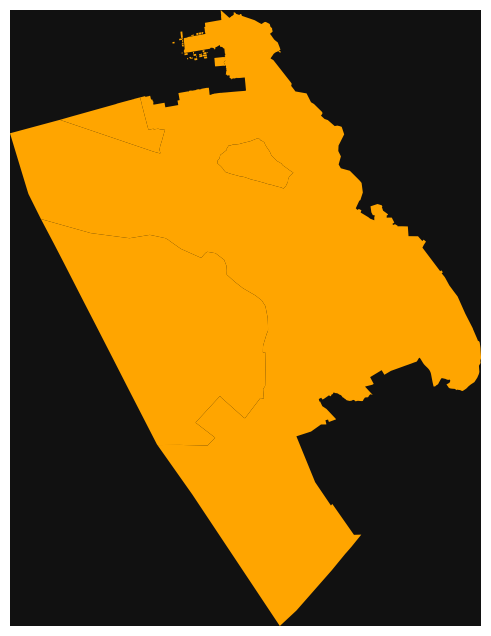

In [3]:
# get the boundary polygons for multiple cities, save as shapefile, project to UTM, and plot
place_names = ['Berkeley, California, USA', 
               'Oakland, California, USA',
               'Piedmont, California, USA',
               'Emeryville, California, USA',
               'Alameda, Alameda County, CA, USA']
east_bay = ox.geocode_to_gdf(place_names)
#ox.save_gdf_shapefile(east_bay)
east_bay = ox.project_gdf(east_bay)
fig, ax = ox.plot_footprints(east_bay)

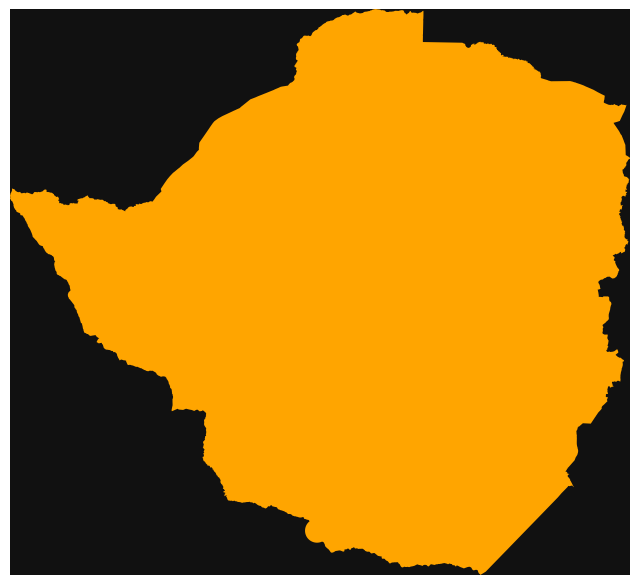

In [4]:
# or get shapes of boroughs, counties, states, countries - anything OpenStreetMap has boundary geometry for
country = ox.geocode_to_gdf('Zimbabwe')
country = ox.project_gdf(country)
fig, ax = ox.plot_footprints(country)

### Download and construct street networks <a class="anchor" id="section1_3"></a>

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [OSMnx examples](https://github.com/gboeing/osmnx).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

 #### Method 1: Pass a bounding box<a class="anchor" id="section1_3_1"></a>
 This constructs the network from all the OSM nodes and ways within the bounding box.

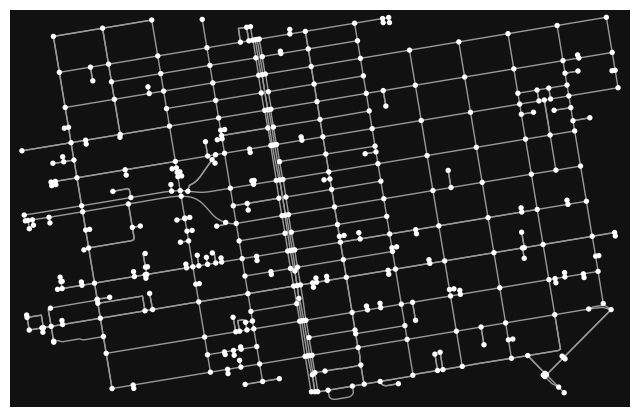

In [5]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

#### Method 2: Pass a lat-long point and bounding box distance in meters <a class="anchor" id="section1_3_2"></a>
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

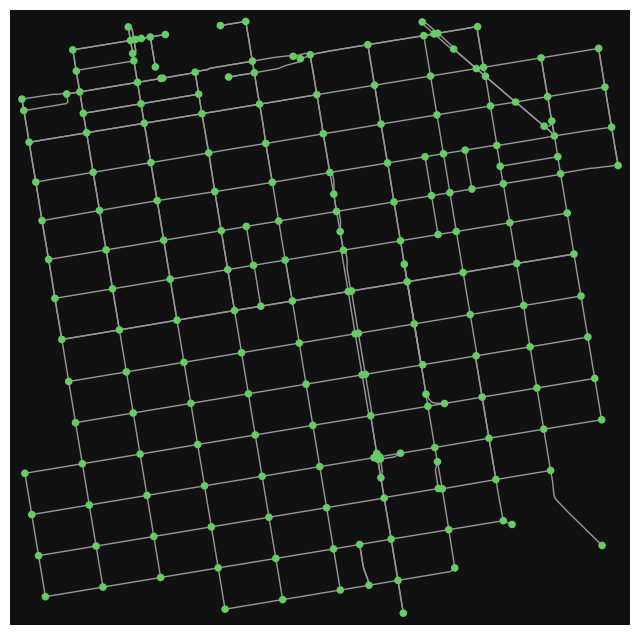

In [6]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G2 = ox.graph_from_point(location_point, dist=750, dist_type='bbox', network_type='drive')
G2 = ox.project_graph(G2)
fig, ax = ox.plot_graph(G2, node_size=30, node_color='#66cc66')

#### Method 3: Pass a (lat,lon) point and *network* distance in meters <a class="anchor" id="section1_3_3"></a>

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it prunes the network by removing all nodes further than *n* meters from the point along the network.

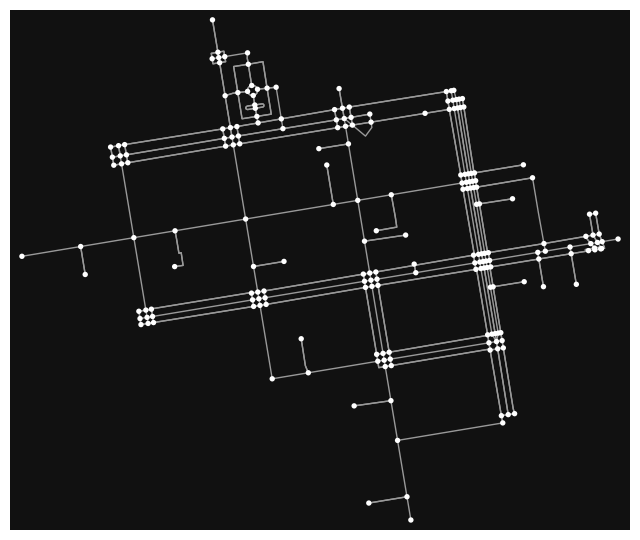

In [7]:
# same point again, but create network only of nodes within 500m along the network from point
G3 = ox.graph_from_point(location_point, dist=500, dist_type='network')
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

*Note* the plot above shows the network within 500m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).

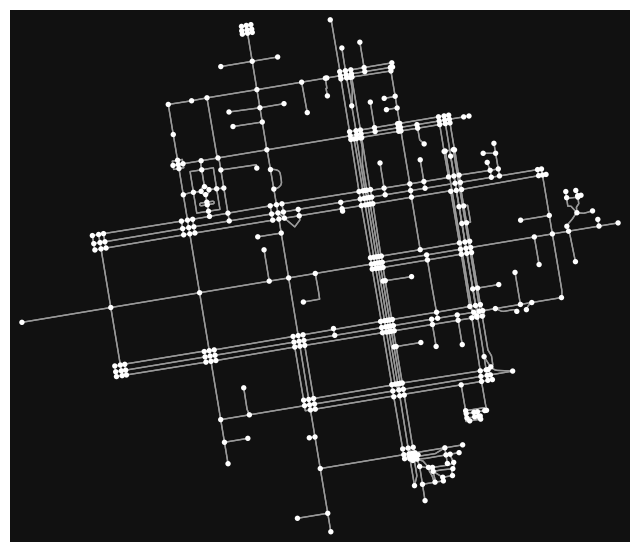

In [8]:
# create network only of nodes within 500m walking along the network from point
G3 = ox.graph_from_point(location_point, dist=500, dist_type='network', network_type='walk')
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

#### Method 4: Pass an address and distance (*bounding box* or *network*) in meters <a class="anchor" id="section1_3_4"></a>
This geocodes the address, creates a bounding box, downloads the network, then prunes it by network distance (if distance_type='network').

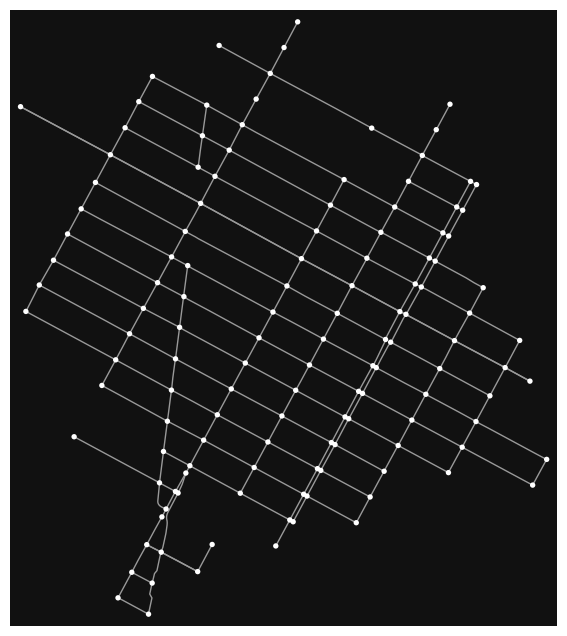

In [9]:
# network from address, including only nodes within 1km along the network from the address
G4 = ox.graph_from_address(address='350 5th Ave, New York, NY', 
                              dist=1000, dist_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
G4_projected = ox.project_graph(G4)
fig, ax = ox.plot_graph(G4_projected)

#### Method 5: Pass a place name <a class="anchor" id="section1_3_5"></a>

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then prunes all nodes that lie outside the place's boundary polygon.

In [10]:
# create the street network within the city of Piedmont's borders
G5 = ox.graph_from_place('Piedmont, California, USA', network_type='walk')
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected)

KeyboardInterrupt: 

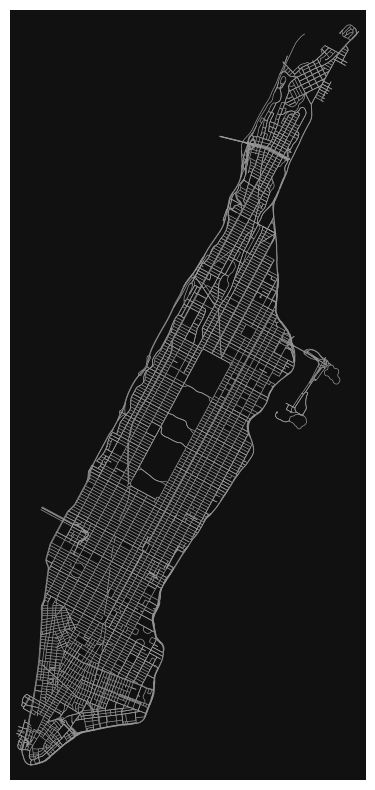

In [ ]:
# create the street network within Manhattan
G5 = ox.graph_from_place('Manhattan, New York, NY, USA', network_type='drive')
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, figsize=(10,10), node_size=0, edge_linewidth=0.5)

/Users/trivikverma/opt/anaconda3/envs/gds/lib/python3.9/site-packages/osmnx/graph.py:488: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


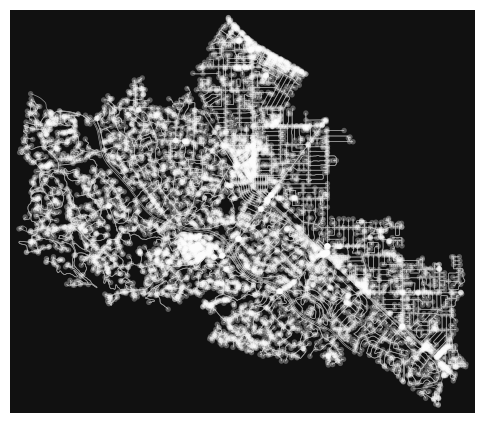

/Users/trivikverma/opt/anaconda3/envs/gds/lib/python3.9/site-packages/osmnx/io.py:107: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [ ]:
# you can also pass multiple places as a mixed list of strings and/or structured queries
places = ['Los Altos, California, USA',
          {'city':'Los Altos Hills', 'state':'California'},
          'Loyola, California']
G5 = ox.graph_from_place(places, clean_periphery=False)
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, figsize=(6,6), node_alpha=0.3, edge_linewidth=0.5)
ox.save_graph_shapefile(G5,'silicon-valley')

### Simplifying street network topology <a class="anchor" id="section1_4"></a>

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs). For a more in-depth demonstration of topological simplification with OSMnx, see [OSMnx examples](https://github.com/gboeing/osmnx).

In [ ]:
# create a network around some (lat, lon) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, dist=500, simplify=False)

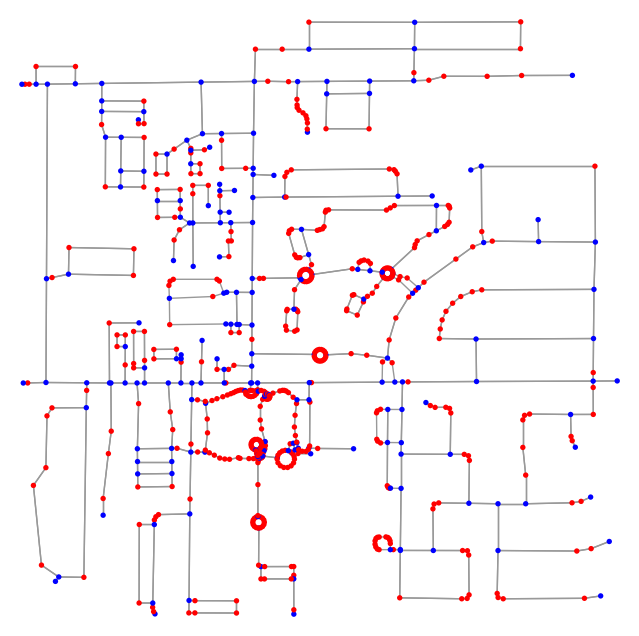

In [ ]:
# turn off strict mode and see what nodes we'd remove, in red
nc = ['b' if ox.simplification._is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3, bgcolor='#FFFFFF')

The red and blue dots above are OSM nodes. We'll remove the nodes in red as they're not real network nodes.

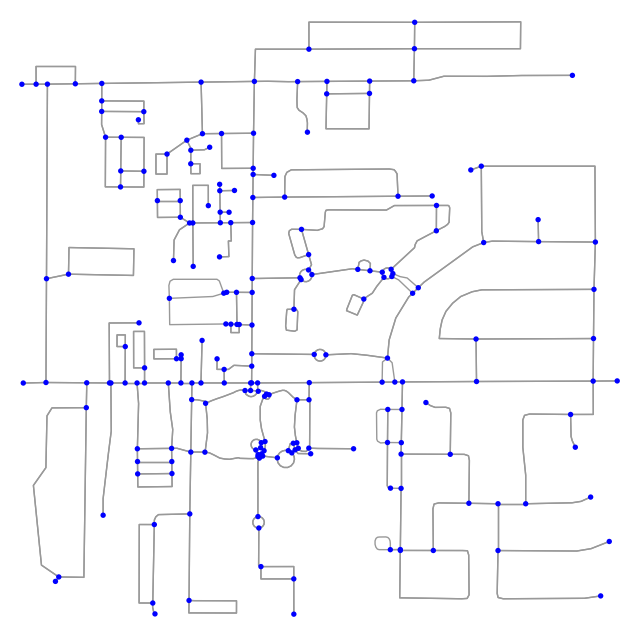

In [ ]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3, bgcolor='#FFFFFF')

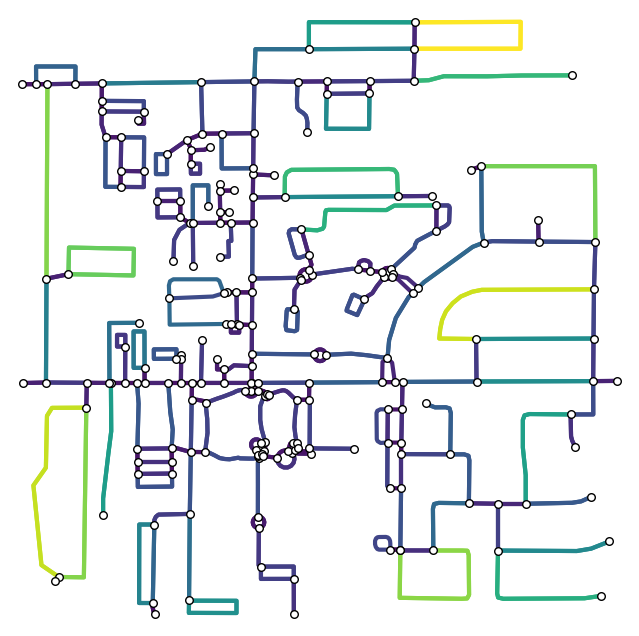

In [ ]:
# show the simplified network with edges colored by edge length
ec = ox.plot.get_edge_colors_by_attr(G, attr='length')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3, bgcolor='#FFFFFF')

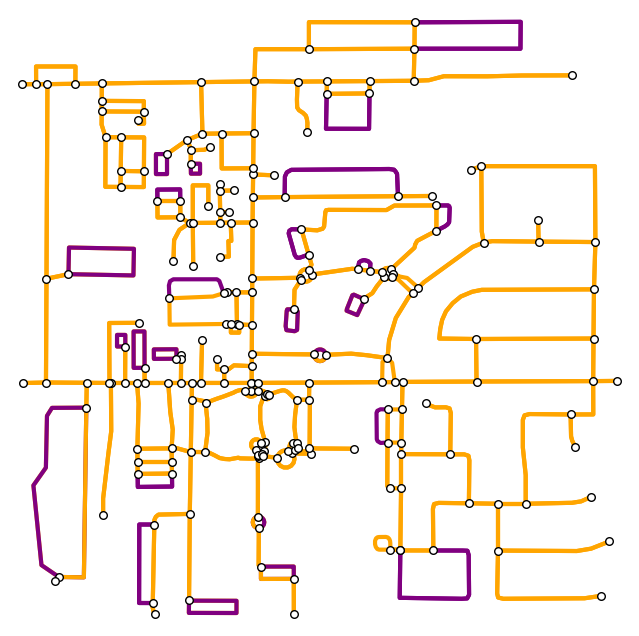

In [ ]:
# highlight all parallel edges in purple
ec = ['orange' if key == 0 else 'purple' for u, v, key in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3, bgcolor='#FFFFFF')

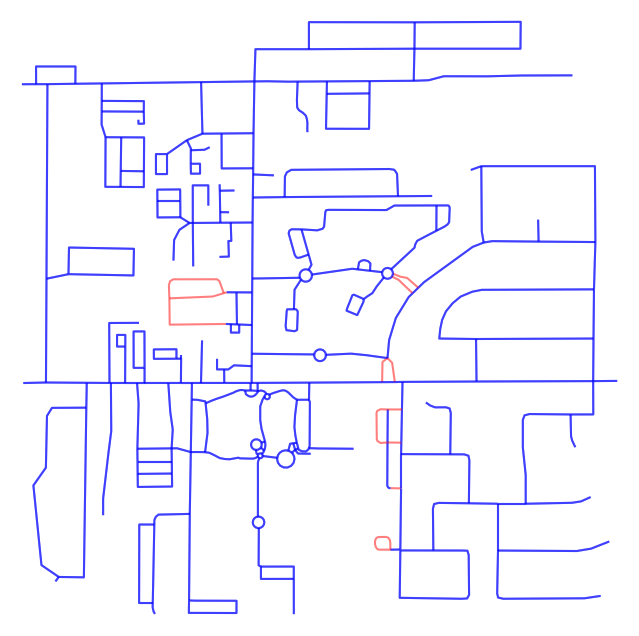

In [ ]:
# highlight all the one-way edges in the mission district network from earlier
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5, bgcolor='#FFFFFF')

### Saving networks to disk <a class="anchor" id="section1_5"></a>

For more examples of saving and loading networks to/from disk, see [OSMnx examples](https://github.com/gboeing/osmnx).

In [ ]:
# save street network as ESRI shapefile to work with in GIS
ox.save_graph_shapefile(G, 'network-shape')

/Users/trivikverma/opt/anaconda3/envs/gds/lib/python3.9/site-packages/osmnx/io.py:107: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [ ]:
# save street network as GraphML file to work with in networkx or gephi
ox.save_graphml(G, 'network.graphml')

In [ ]:
# save street network as SVG to work with in Adobe Illustrator
fig, ax = ox.plot_graph(G, show=False, save=True, close=True, filepath='./network.svg')

In [ ]:
# get one of each network type and save to disk as image and shapefile
for nt in ['all_private', 'all', 'bike', 'walk', 'drive', 'drive_service']:
    G = ox.graph_from_address('N Sicily Pl, Chandler, AZ', network_type=nt, dist=1500)
    filename = 'az-{}'.format(nt)
    fig, ax = ox.plot_graph(G, node_color='none', save=True, filepath=filename+'.png', show=False, close=True)

For examples of working with these street networks in networkx, see [OSMnx examples](https://github.com/gboeing/osmnx).

### Calculate basic network metrics <a class="anchor" id="section1_6"></a>

In [ ]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats['circuity_avg']

1.0806759696834884

## Use OSMnx to create and analyze a NetworkX street network <a class="anchor" id="chapter2"></a>


### Calculate basic (and more advanced) street network metrics <a class="anchor" id="section2_1"></a>

In [ ]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place('Piedmont, California, USA', network_type='drive_service'))

In [ ]:
stats

{'n': 446,
 'm': 1145,
 'k_avg': 5.134529147982063,
 'edge_length_total': 120558.65799999992,
 'edge_length_avg': 105.29140436681216,
 'streets_per_node_avg': 2.7780269058295963,
 'streets_per_node_counts': {0: 0, 1: 77, 2: 2, 3: 314, 4: 50, 5: 2, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1726457399103139,
  2: 0.004484304932735426,
  3: 0.7040358744394619,
  4: 0.11210762331838565,
  5: 0.004484304932735426,
  6: 0.002242152466367713},
 'intersection_count': 369,
 'street_length_total': 62248.58100000001,
 'street_segment_count': 595,
 'street_length_avg': 104.61946386554624,
 'circuity_avg': 1.1090492282977602,
 'self_loop_proportion': 0.005042016806722689}

In [ ]:
stats['circuity_avg']

1.1090492282977602

To calculate density-based metrics, you must also pass the network's bounding area in square meters (otherwise `basic_stats()` will just skip them in the calculation):

In [ ]:
# get the street network for a place, and its area in square meters (by projecting)
place = 'Piedmont, California, USA'
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [ ]:
# calculate basic and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                             446
m                                                                            1145
k_avg                                                                    5.134529
edge_length_total                                                      120558.658
edge_length_avg                                                        105.291404
streets_per_node_avg                                                     2.778027
streets_per_node_counts            {0: 0, 1: 77, 2: 2, 3: 314, 4: 50, 5: 2, 6: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.1726457399103139, 2: 0.004484304...
intersection_count                                                            369
street_length_total                                                     62248.581
street_segment_count                                                          595
street_length_avg                                                      104.619464
circuity_avg    

Notice that this returns the basic stats as a dict, which we threw into a pandas series. Degree counts and proportions are nested dicts inside it. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [ ]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportions'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_node_counts']
del stats['streets_per_node_proportions']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats)).T

,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,...,int_4_count,int_5_count,int_6_count,int_0_prop,int_1_prop,int_2_prop,int_3_prop,int_4_prop,int_5_prop,int_6_prop
0,446.0,1145.0,5.134529,120558.658,105.291404,2.778027,369.0,62248.581,595.0,104.619464,...,50.0,2.0,1.0,0.0,0.172646,0.004484,0.704036,0.112108,0.004484,0.002242


In [ ]:
# proportion of intersections that are cul-de-sacs, T-intersections, and X-intersections?
print(stats['int_1_prop'])
print(stats['int_3_prop'])
print(stats['int_4_prop'])

0.1726457399103139
0.7040358744394619
0.11210762331838565


In [ ]:
# how many streets emanate from each intersection?
ox.stats.streets_per_node_counts(G)

{0: 0, 1: 77, 2: 2, 3: 314, 4: 50, 5: 2, 6: 1}

### Inside a NetworkX graph <a class="anchor" id="section2_2"></a>

In [ ]:
# nodes
list(G.nodes(data=True))[0:2]

[(53017091, {'y': 37.8262501, 'x': -122.2476037, 'street_count': 3}),
 (53018397, {'y': 37.8242243, 'x': -122.247194, 'street_count': 3})]

In [ ]:
# edges
list(G.edges(keys=True, data=True))[0:2]

[(53017091,
  53064327,
  0,
  {'osmid': 6345781,
   'name': 'Rose Avenue',
   'highway': 'residential',
   'oneway': False,
   'reversed': False,
   'length': 231.335}),
 (53017091,
  53075599,
  0,
  {'osmid': 6345781,
   'name': 'Rose Avenue',
   'highway': 'residential',
   'oneway': False,
   'reversed': True,
   'length': 121.11399999999999,
   'geometry': <shapely.geometry.linestring.LineString at 0x15993f4f0>})]

In [ ]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

AttributeError: module 'osmnx' has no attribute 'get_nearest_node'

In [ ]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

In [ ]:
# plot the route showing origin/destination lat-long points in big size
fig, ax = ox.plot_graph_route(G, route, orig_dest_size=800)

## Spatial weights <a class="anchor" id="chapter3"></a>

In this session we will be learning the ins and outs of one of the key pieces in spatial analysis: spatial weights matrices. These are structured sets of numbers that formalize geographical relationships between the observations in a dataset. Essentially, a spatial weights matrix of a given geography is a positive definite matrix of dimensions $N$ by $N$, where $N$ is the total number of observations:

$$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)
$$

where each cell $w_{ij}$ contains a value that represents the degree of spatial contact or interaction between observations $i$ and $j$. A fundamental concept in this context is that of *neighbor* and *neighborhood*. By convention, elements in the diagonal ($w_{ij}$) are set to zero. A *neighbor* of a given observation $i$ is another observation with which $i$ has some degree of connection. In terms of $W$, $i$ and $j$ are thus neighbors if $w_{ij} > 0$. Following this logic, the neighborhood of $i$ will be the set of observations in the system with which it has certain connection, or those observations with a weight greater than zero.

There are several ways to create such matrices, and many more to transform them so they contain an accurate representation that aligns with the way we understand spatial interactions between the elements of a system. In this session, we will introduce the most commonly used ones and will show how to compute them with `PySAL`.

In [11]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
from libpysal.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### Data <a class="anchor" id="section3_1"></a>

For this tutorial, we will use again the recently released 2015 Index of Multiple Deprivation (IMD) for England and Wales. This dataset can be most easily downloaded from the CDRC data store ([link](https://data.cdrc.ac.uk/dataset/cdrc-english-indices-of-deprivation-2015-geodata-pack-liverpool-e08000012)) and, since it already comes both in tabular as well as spatial data format (shapefile), it does not need merging or joining to additional geometries.

In addition, we will be using the lookup between LSOAs and Medium Super Output Areas (MSOAs), which can be downloaded on this [link](http://www.ons.gov.uk/ons/external-links/social-media/g-m/2011-oas-to-2011-lower-layer-super-output-areas--lsoas---middle-layer-super-output-areas--msoa--and-lads.html). This connects each LSOA polygon to the MSOA they belong to. MSOAs are a coarser geographic delineation from the Office of National Statistics (ONS), within which LSOAs are nested. That is, no LSOA boundary crosses any of an MSOA.

As usual, let us set the paths to the folders containing the files before anything so we can then focus on data analysis exclusively (keep in mind the specific paths will probably be different for your computer):

In [12]:
# This will be different on your computer and will depend on where
# you have downloaded the files
imd_shp = 'data/lab05_imd.shp'
lookup_path = 'data/output_areas_(2011)_to_lower_layer_super_output_areas_(2011)_to_middle_layer_super_output_areas_(2011)_to_local_authority_districts_(2011)_e+w_lookup/'

Let us load the IMD data first:

In [13]:
# Read the file in
imd = gpd.read_file(imd_shp)

#imd_shp = imd_shp.set_index('LSOA11CD')
# Display summary
imd.info()

DriverError: data/lab05_imd.shp: No such file or directory

### Building spatial weights in `PySAL` <a class="anchor" id="section3_2"></a>

#### Contiguity <a class="anchor" id="section3_2_1"></a>

Contiguity weights matrices define spatial connections through the existence of common boundaries. This makes it directly suitable to use with polygons: if two polygons share boundaries to some degree, they will be labeled as neighbors under these kinds of weights. Exactly how much they need to share is what differenciates the two approaches we will learn: queen and rook.

* **Queen**

Under the queen criteria, two observations only need to share a vortex (a single point) of their boundaries to be considered neighbors. Constructing a weights matrix under these principles can be done by running:

In [ ]:
w_queen = weights.Queen.from_dataframe(imd, idVariable="LSOA11CD")
w_queen

The command above creates an object `w_queen` of the class `W`. This is the format in which spatial weights matrices are stored in `PySAL`. By default, the weights builder (`Queen.from_dataframe`) will use the index of the table, which is useful so we can keep everything in line easily.

A `W` object can be queried to find out about the contiguity relations it contains. For example, if we would like to know who is a neighbor of observation `E01006690`:

In [ ]:
w_queen['E01006690']

This returns a Python dictionary that contains the ID codes of each neighbor as keys, and the weights they are assigned as values. Since we are looking at a raw queen contiguity matrix, every neighbor gets a weight of one. If we want to access the weight of a specific neighbor, `E01006691` for example, we can do recursive querying:

In [ ]:
w_queen['E01006690']['E01006691']

`W` objects also have a direct way to provide a list of all the neighbors or their weights for a given observation. This is thanks to the `neighbors` and `weights` attributes:

In [ ]:
w_queen.neighbors['E01006690']

In [ ]:
w_queen.weights['E01006690']

Once created, `W` objects can provide much information about the matrix, beyond the basic attributes one would expect. We have direct access to the number of neighbors each observation has via the attribute `cardinalities`. For example, to find out how many neighbors observation `E01006524` has:

In [ ]:
w_queen.cardinalities['E01006524']

Since `cardinalities` is a dictionary, it is direct to convert it into a `Series` object:

In [ ]:
queen_card = pd.Series(w_queen.cardinalities)
queen_card.head()

This allows, for example, to access quick plotting, which comes in very handy to get an overview of the size of neighborhoods in general:

In [ ]:
sns.distplot(queen_card, bins=10)

The figure above shows how most observations have around five neighbors, but there is some variation around it. The distribution also seems to follow a symmetric form, where deviations from the average occur both in higher and lower values almost evenly.

Some additional information about the spatial relationships contained in the matrix are also easily available from a `W` object. Let us tour over some of them:

In [ ]:
# Number of observations
w_queen.n

In [ ]:
# Average number of neighbors
w_queen.mean_neighbors

In [ ]:
# Min number of neighbors
w_queen.min_neighbors

In [ ]:
# Max number of neighbors
w_queen.max_neighbors

In [ ]:
# Islands (observations disconnected)
w_queen.islands

In [ ]:
# Order of IDs (first five only in this case)
w_queen.id_order[:5]

In [ ]:
imd = imd.set_index("LSOA11CD")

Spatial weight matrices can be explored visually in other ways. For example, we can pick an observation and visualize it in the context of its neighborhood. The following plot does exactly that by zooming into the surroundings of LSOA `E01006690` and displaying its polygon as well as those of its neighbors:

In [ ]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
imd.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = imd.loc[['E01006690'], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = imd.loc[w_queen['E01006690'], :]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Queen neighbors of `E01006690`")
# Style and display on screen
ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

Note how the figure is built gradually, from the base map (L. 4-5), to the focal point (L. 9), to its neighborhood (L. 11-13). Once the entire figure is plotted, we zoom into the area of interest (L. 19-20).

* **Rook**

Rook contiguity is similar to and, in many ways, superseded by queen contiguity. However, since it sometimes comes up in the literature, it is useful to know about it. The main idea is the same: two observations are neighbors if they share some of their boundary lines. However, in the rook case, it is not enough with sharing only one point, it needs to be at least a segment of their boundary. In most applied cases, these differences usually boil down to how the geocoding was done, but in some cases, such as when we use raster data or grids, this approach can differ more substantively and it thus makes more sense.

From a technical point of view, constructing a rook matrix is very similar:

In [ ]:
w_rook = weights.Rook.from_dataframe(imd)
w_rook

The output is of the same type as before, a `W` object that can be queried and used in very much the same way as any other one.

---
**[Optional exercise]**

Create a similar map for the rook neighbors of polygon `E01006580`. 

How would it differ if the spatial weights were created based on the queen criterion?

---

#### Distance <a class="anchor" id="section3_2_3"></a>

Distance based matrices assign the weight to each pair of observations as a function of how far from each other they are. How this is translated into an actual weight varies across types and variants, but they all share that the ultimate reason why two observations are assigned some weight is due to the distance between them.

* **K-Nearest Neighbors**

One approach to define weights is to take the distances between a given observation and the rest of the set, rank them, and consider as neighbors the $k$ closest ones. That is exactly what the $k$-nearest neighbors (KNN) criterium does.

To calculate KNN weights, we can use a similar function as before and derive them from a shapefile:

In [ ]:
knn5 = weights.KNN.from_dataframe(imd, k=5)
knn5

Note how we need to specify the number of nearest neighbors we want to consider with the argument `k`. Since it is a polygon shapefile that we are passing, the function will automatically compute the centroids to derive distances between observations. Alternatively, we can provide the points in the form of an array, skipping this way the dependency of a file on disk:

In [ ]:
# Extract centroids
cents = imd.centroid
# Extract coordinates into an array
pts = np.array([(pt.x, pt.y) for pt in cents])
# Compute KNN weights
knn5_from_pts = weights.KNN.from_array(pts, k=5)
knn5_from_pts

* **Distance band**
 
Another approach to build distance-based spatial weights matrices is to draw a circle of certain radious and consider neighbor every observation that falls within the circle. The technique has two main variations: binary and continuous. In the former one, every neighbor is given a weight of one, while in the second one, the weights can be further tweaked by the distance to the observation of interest.

To compute binary distance matrices in `PySAL`, we can use the following command:

In [ ]:
w_dist1kmB = weights.DistanceBand.from_dataframe(imd, 1000)

**NOTE** how we approach this in a different way, by using the method `from_shapefile` we do not build the `W` based on the table `imd`, but instead use directly the file the table came from (which we point at using `imd_shp`, the path). Note also how we need to include the name of the column where the index of the table is stored (`LSOA11CD`, the LSOA code) so the matrix is aligned and indexed in the same way as the tabl. Once built, however, the output is of the same kind as before, a `W` object.

This creates a binary matrix that considers neighbors of an observation every polygon whose centroid is closer than 1,000 metres (1Km) of the centroid of such observation. Check, for example, the neighborhood of polygon `E01006690`:

In [ ]:
w_dist1kmB['E01006690']

Note that the units in which you specify the distance directly depend on the CRS in which the spatial data are projected, and this has nothing to do with the weights building but it can affect it significantly. Recall how you can check the CRS of a `GeoDataFrame`:

In [ ]:
imd.crs

In this case, you can see the unit is expressed in metres (`m`), hence we set the threshold to 1,000 for a circle of 1km of radious.

An extension of the weights above is to introduce further detail by assigning different weights to different neighbors within the radious circle based on how far they are from the observation of interest. For example, we could think of assigning the inverse of the distance between observations $i$ and $j$ as $w_{ij}$. This can be computed with the following command:

In [ ]:
w_dist1kmC = weights.DistanceBand.from_dataframe(imd, 1000, binary=False)

In `w_dist1kmC`, every observation within the 1km circle is assigned a weight equal to the inverse distance between the two:

$$
w_{ij} = \dfrac{1}{d_{ij}}
$$

This way, the further apart $i$ and $j$ are from each other, the smaller the weight $w_{ij}$ will be.

Contrast the binary neighborhood with the continuous one for `E01006690`:

In [ ]:
w_dist1kmC['E01006690']

---

**[Optional exercise]**

Explore the help for functions `weights.DistanceBand.from_array` and try to use them to replicate `w_dist1kmB` and `w_dist1kmC`.

---

Following this logic of more detailed weights through distance, there is a temptation to take it further and consider everyone else in the dataset as a neighbor whose weight will then get modulated by the distance effect shown above. However, although conceptually correct, this approach is not always the most computationally or practical one. Because of the nature of spatial weights matrices, particularly because of the fact their size is $N$ by $N$, they can grow substantially large. A way to cope with this problem is by making sure they remain fairly *sparse* (with many zeros). Sparsity is typically ensured in the case of contiguity or KNN by construction but, with inverse distance, it needs to be imposed as, otherwise, the matrix could be potentially entirely dense (no zero values other than the diagonal). In practical terms, what is usually done is to impose a distance threshold beyond which no weight is assigned and interaction is assumed to be non-existent. Beyond being computationally feasible and scalable, results from this approach usually do not differ much from a fully "dense" one as the additional information that is included from further observations is almost ignored due to the small weight they receive. In this context, a commonly used threshold, although not always best, is that which makes every observation to have at least one neighbor. 

Such a threshold can be calculated as follows:

In [ ]:
min_thr = weights.min_threshold_dist_from_shapefile(imd_shp)
min_thr

Which can then be used to calculate an inverse distance weights matrix:

In [ ]:
w_min_dist = weights.DistanceBand.from_dataframe(imd, min_thr, binary=False)

---

**Optional extension [Lecture figure]**

Below is how to build a visualization for distance-based weights that displays the polygons, highlighting the focus and its neighbors, and then overlays the centroids and the buffer used to decide whether a polygon is a neighbor or not. Since this is distance-based weights, there needs to be a way to establish distance between two polygons and, in this case, the distance between their centroids is used.

In [ ]:
# Setup figure
f, ax = plt.subplots(1, figsize=(4, 4))
# Plot base layer of polygons
imd.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = imd.loc[['E01006690'], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = imd.loc[w_dist1kmC['E01006690'], :]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Plot 1km buffer
buf = focus.centroid.buffer(1000)
buf.plot(edgecolor='red', facecolor='none', ax=ax)
# Plot centroids of neighbor
pts = np.array([(pt.x, pt.y) for pt in imd.centroid])
ax.plot(pts[:, 0], pts[:, 1], color='#00d8ea', 
        linewidth=0, alpha=0.75, marker='o', markersize=4)
# Title
f.suptitle("Neighbors within 1km of `E01006690`")
# Style, zoom and display on screen
ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

---

#### Block weights <a class="anchor" id="section3_2_6"></a>

Block weights connect every observation in a dataset that belongs to the same category in a list provided ex-ante. Usually, this list will have some relation to geography an the location of the observations but, technically speaking, all one needs to create block weights is a list of memberships. In this class of weights, neighboring observations, those in the same group, are assigned a weight of one, and the rest receive a weight of zero.

In this example, we will build a spatial weights matrix that connects every LSOA with all the other ones in the same MSOA. To do this, we first need a lookup list that connects both kinds of geographies:

In [ ]:
# NOTE: disregard the warning in pink that might come from running 
#       this cell
file_name = 'OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv'
lookup = pd.read_csv(lookup_path+file_name, encoding='iso-8859-1')
lookup = lookup[['LSOA11CD', 'MSOA11CD']].drop_duplicates(keep='last')\
                                         .set_index('LSOA11CD')['MSOA11CD']
lookup.head()

Since the original file contains much more information than we need for this exercise, note how in line 2 we limit the columns we keep to only two, `LSOA11CD` and `MSOA11CD`. We also add an additional command, `drop_duplicates`, which removes elements whose index is repeated more than once, as is the case in this dataset (every LSOA has more than one row in this table). By adding the `take_last` argument, we make sure that one and only one element of each index value is retained. For ease of use later on, we set the index, that is the name of the rows, to `LSOA11CD`. This will allow us to perform efficient lookups without having to perform full `DataFrame` queries, and it is also a more computationally efficient way to select observations.

For example, if we want to know in which MSOA the polygon `E01000003` is, we just need to type:

In [ ]:
lookup.loc['E01000003']

With the lookup in hand, let us append it to the IMD table to keep all the necessary pieces in one place only:

In [ ]:
imd['MSOA11CD'] = lookup

Now we are ready to build a block spatial weights matrix that connects as neighbors all the LSOAs in the same MSOA. Using `PySAL`, this is a one-line task:

In [ ]:
w_block = weights.block_weights(imd['MSOA11CD'])

In this case, `PySAL` does not allow to pass the argument `idVariable` as above. As a result, observations are named after the the order the occupy in the list:

In [ ]:
w_block[0]

The first element is neighbor of observations 218, 129, 220, and 292, all of them with an assigned weight of 1. However, it is possible to correct this by using the additional method `remap_ids`:

In [ ]:
w_block.remap_ids(imd.index)

Now if you try `w_bloc[0]`, it will return an error. But if you query for the neighbors of an observation by its LSOA id, it will work:

In [ ]:
w_block['E01006512']

---

**[Optional exercise]**

For block weights, create a similar map to that of queen neighbors of polygon `E01006690`.

---

### Standardizing `W` matrices <a class="anchor" id="section3_3"></a>

In the context of many spatial analysis techniques, a spatial weights matrix with raw values (e.g. ones and zeros for the binary case) is not always the best suiting one for analysis and some sort of transformation is required. This implies modifying each weight so they conform to certain rules. `PySAL` has transformations baked right into the `W` object, so it is possible to check the state of an object as well as to modify it.

Consider the original queen weights, for observation `E01006690`:

In [ ]:
w_queen['E01006690']

Since it is contiguity, every neighbor gets one, the rest zero weight. We can check if the object `w_queen` has been transformed or not by calling the argument `transform`:

In [ ]:
w_queen.transform

where `O` stands for "original", so no transformations have been applied yet. If we want to apply a row-based transformation, so every row of the matrix sums up to one, we modify the `transform` attribute as follows:

In [ ]:
w_queen.transform = 'R'

Now we can check the weights of the same observation as above and find they have been modified:

In [ ]:
w_queen['E01006690']

Save for precission issues, the sum of weights for all the neighbors is one:

In [ ]:
pd.Series(w_queen['E01006690']).sum()

Returning the object back to its original state involves assigning `transform` back to original:

In [ ]:
w_queen.transform = 'O'

In [ ]:
w_queen['E01006690']

`PySAL` supports the following transformations:

* `O`: original, returning the object to the initial state.
* `B`: binary, with every neighbor having assigned a weight of one.
* `R`: row, with all the neighbors of a given observation adding up to one.
* `V`: variance stabilizing, with the sum of all the weights being constrained to the number of observations.

### Reading and Writing spatial weights in `PySAL` <a class="anchor" id="section3_4"></a>

Sometimes, if a dataset is very detailed or large, it can be costly to build the spatial weights matrix of a given geography and, despite the optimizations in the `PySAL` code, the computation time can quickly grow out of hand. In these contexts, it is useful to not have to re-build a matrix from scratch every time we need to re-run the analysis. A useful solution in this case is to build the matrix once, and save it to a file where it can be reloaded at a later stage if needed.

`PySAL` has a common way to write any kind of `W` object into a file using the command `open`. The only element we need to decide for ourselves beforehand is the format of the file. Although there are several formats in which spatial weight matrices can be stored (have a look at the [list](http://pysal.readthedocs.org/en/latest/users/tutorials/fileio.html) of supported ones by `PySAL`), we will focused on the two most commonly used ones:

* **`.gal`** files for contiguity weights

Contiguity spatial weights can be saved into a `.gal` file with the following commands:

In [ ]:
# Open file to write into
fo = psopen('imd_queen.gal', 'w')
# Write the matrix into the file
fo.write(w_queen)
# Close the file
fo.close()

The process is composed by the following three steps:

1. Open a target file for `w`riting the matrix, hence the `w` argument. In this case, if a file `imd_queen.gal` already exists, it will be overwritten, so be careful.
1. Write the `W` object into the file.
1. Close the file. This is important as some additional information is written into the file at this stage, so failing to close the file might have unintended consequences.

Once we have the file written, it is possible to read it back into memory with the following command:

In [ ]:
w_queen2 = psopen('imd_queen.gal', 'r').read()
w_queen2

Note how we now use `r` instead of `w` because we are `r`eading the file, and also notice how we open the file and, in the same line, we call `read()` directly.

* **`.gwt`** files for distance-based weights.

A very similar process to the one above can be used to read and write distance based weights. The only difference is specifying the right file format, `.gwt` in this case. So, if we want to write `w_dist1km` into a file, we will run:

In [ ]:
# Open file
fo = psopen('imd_dist1km.gwt', 'w')
# Write matrix into the file
fo.write(w_dist1kmC)
# Close file
fo.close()

And if we want to read the file back in, all we need to do is:

In [ ]:
w_dist1km2 = psopen('imd_dist1km.gwt', 'r').read()

Note how, in this case, you will probably receive a warning alerting you that there was not a `DBF` relating to the file. This is because, by default, `PySAL` takes the order of the observations in a `.gwt` from a shapefile. If this is not provided, `PySAL` cannot entirely determine all the elements and hence the resulting `W` might not be complete (islands, for example, can be missing). To fully complete the reading of the file, we can remap the ids as we have seen above:

In [ ]:
w_dist1km2.remap_ids(imd.index)

### Spatial Lag <a class="anchor" id="section3_5"></a>

One of the most direct applications of spatial weight matrices is the so-called *spatial lag*. The spatial lag of a given variable is the product of a spatial weight matrix and the variable itself:

$$
Y_{sl} = W Y
$$

where $Y$ is a Nx1 vector with the values of the variable. Recall that the product of a matrix and a vector equals the sum of a row by column element multiplication for the resulting value of a given row. In terms of the spatial lag:

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

If we are using row-standardized weights, $w_{ij}$ becomes a proportion between zero and one, and $y_{sl-i}$ can be seen as the average value of $Y$ in the neighborhood of $i$.

The spatial lag is a key element of many spatial analysis techniques, as we will see later on and, as such, it is fully supported in `PySAL`. To compute the spatial lag of a given variable, `imd_score` for example:

In [ ]:
# Row-standardize the queen matrix
w_queen.transform = 'R'
# Compute spatial lag of `imd_score`
w_queen_score = weights.lag_spatial(w_queen, imd['imd_score'])
# Print the first five elements
w_queen_score[:5]

Line 4 contains the actual computation, which is highly optimized in `PySAL`. Note that, despite passing in a `pd.Series` object, the output is a `numpy` array. This however, can be added directly to the table `imd`:

In [ ]:
imd['w_queen_score'] = w_queen_score

---
**[Optional exercise]**

Explore the spatial lag of `w_queen_score` by constructing a density/histogram plot similar to those created in Lab 2. Compare these with one for `imd_score`. What differences can you tell?

<!--
sns.distplot(imd['imd_score'])

sns.distplot(imd['w_queen_score'])
-->

---

### Moran Plot <a class="anchor" id="section3_6"></a>

The Moran Plot is a graphical way to start exploring the concept of spatial autocorrelation, and it is a good application of spatial weight matrices and the spatial lag. In essence, it is a standard scatter plot in which a given variable (`imd_score`, for example) is plotted against *its own* spatial lag. Usually, a fitted line is added to include more information:

In [ ]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x="imd_score", y="w_queen_score", data=imd, ci=None)
# Display
plt.show()

In order to easily compare different scatter plots and spot outlier observations, it is common practice to standardize the values of the variable before computing its spatial lag and plotting it. This can be accomplished by substracting the average value and dividing the result by the standard deviation:

$$
z_i = \dfrac{y - \bar{y}}{\sigma_y}
$$

where $z_i$ is the standardized version of $y_i$, $\bar{y}$ is the average of the variable, and $\sigma$ its standard deviation.

Creating a standardized Moran Plot implies that average values are centered in the plot (as they are zero when standardized) and dispersion is expressed in standard deviations, with the rule of thumb of values greater or smaller than two standard deviations being *outliers*. A standardized Moran Plot also partitions the space into four quadrants that represent different situations:

1. High-High (*HH*): values above average surrounded by values above average.
1. Low-Low (*LL*): values below average surrounded by values below average.
1. High-Low (*HL*): values above average surrounded by values below average.
1. Low-High (*LH*): values below average surrounded by values above average.

These will be further explored once spatial autocorrelation has been properly introduced in subsequent lectures.

In [ ]:
# Standardize the IMD scores
std_imd = (imd['imd_score'] - imd['imd_score'].mean()) / imd['imd_score'].std()
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
std_w_imd = pd.Series(weights.lag_spatial(w_queen, std_imd), index=std_imd.index)
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_imd, y=std_w_imd, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

---

**[Optional exercise]** 

Create a standardized Moran Plot for each of the components of the IMD:

* Crime
* Education
* Employment
* Health
* Housing
* Income
* Living environment

**Bonus good karma** if you can generate all the plots with a `for` loop.

**Bonus great karma-II** if you explore the functionality of Seaborn's `jointplot` ([link](http://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#plotting-a-regression-in-other-contexts) and [link](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html#seaborn.jointplot)) to create a richer Moran plot.

<!--
w_queen.transform = 'R'
for col in ['crime', 'education', 'employment', 'health', 'housing', 'income', 'living_env']:
    stdd = (imd[col] - imd[col].mean()) / imd[col].std()
    sl = pd.Series(ps.lag_spatial(w_queen, stdd), index=stdd.index)
    sns.jointplot(x=stdd, y=sl, kind="reg")
-->

